# Unet Segmentation Model

This notebook details training a segmentation model to create masks for container ships in satellite images. To do this, we are going to use a U-Net model, which has become the go-to architecture for segmentation problems.

We want the model to process the image, then return a mask of the same size as the original image. One way to go about doing this would be to first use a convolutional model as an encoder to process the input image into a smaller, deeper tensor. Then use a decoder to upsample from that convolutional output back to the original image size. This strategy works, but only so well. The issue is that a huge amount of information in the input is compressed into the convolutional output of the encoder. Trying to decompress this with the degree of accuracy required for masking is very challenging. Good masks require fine detail at the edges - precise boundaries are important. Trying to retain this information through the convolutional encoder is simply hard.

U-Net provides a solution to this. A U-Net model saves activations from earlier layers in the encoder and passes them to the decoder during upsampling. This allows the decoder to retain image information from early convolutional layers. This architecture is much more proficient at producing high quality masks. Visually, the U-Net looks like this:

![img](unet.png)

[source](https://arxiv.org/pdf/1505.04597.pdf)

## Pretrained Encoders

One way to jump start the performance of a U-Net model is to use a pretrained model for the encoder. Pretrained models have already developed the weights required for fundamental image processing functions like edge and texture detection. These benefits carry over to even distant image recognition tasks, like processing seismic imaging. The model trained in this notebook uses a pretrained resnet34 model as an encoder.

## Loss Function

Segmentation can be viewed as a classification problem - you want to classify every pixel in the input image as either a 0 or 1 depending on if it is part of the mask or not. A simple loss function that works for this task would be binary cross entropy. However we can get better performance if we add on to that.

When it comes to producing high quality masks, the difficulty is on the edge of the mask. The inside of the mask has a bunch of pixels classified as 1 all grouped together. Outside of the mask, every pixel is classified as 0. Classifying the bulk of the inside of the mask 1 and the bulk of the outside as 0 is fairly easy. The difficulty in segmentation happens on the boundaries, where the mask transitions from mostly 1s to mostly 0s. Visually speaking, creating blobby ill defined masks is easy. Creating masks with sharp, accurate, well defined edges is hard.

To push the model towards paying attention to the boundaries, we add a soft dice loss component to the loss function. The dice score looks at how similar the predicted mask is to the target mask by looking at the ratio of true positives to true positives plus false positives plus false negatives. For numerical stability, we add the natural log of the dice score to the loss function.

An additional challenge with this dataset is that many of the ships we need to segment are very small. This leads to an imbalanced classification problem. In fact many of the images are so imbalanced that the model can achieve 99% accuracy by predicting empty masks, as most of the area in each image is just empty ocean. We want to avoid this. 

Another issue that arises is that the standard cross entropy function gives too strong a penalty for correct classifications that do not have sufficiently high probability (ie getting the correct class but at 65% probability). The result is that the model will fail to classify small objects, choosing instead to classify everything as background because there was too strong a penalty with being correct but not correct enough. The solution to these issues is to employ [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf), a version of cross entropy shown to improve classification of small objects. Focal loss weights the cross entropy loss by:

$$-\alpha*(1-p_{t})^\gamma * log(p_{t})$$

Where

$$
p_{t} = \left\{
        \begin{array}{ll}
            p & \quad x = 0 \\
            1-p & \quad otherwise
        \end{array}
    \right.
$$

The effect of the focal loss coefficient is to dampen the loss contribution from higher probability classifications and focus the model on poorly classified examples.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [3]:
torch.backends.cudnn.benchmark=True

In [4]:
PATH = Path('F:/ships')

In [6]:
mask_fns = os.listdir(PATH/'masks')

In [8]:
trn_fns = [i.split('_')[0] + '.jpg' for i in mask_fns]

In [10]:
TRAIN_DN = 'train_v2'

In [11]:
MASKS_DN = 'masks'

In [12]:
x_names = np.array([Path(TRAIN_DN)/o for o in trn_fns])
y_names = np.array([Path(MASKS_DN)/o for o in mask_fns])

In [13]:
x_names[0]

WindowsPath('train_v2/000155de5.jpg')

In [14]:
y_names[0]

WindowsPath('masks/000155de5_mask.png')

In [15]:
n = len(x_names)
n

42556

In [16]:
val_idxs = get_cv_idxs(n, val_pct=0.15)

In [17]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [18]:
test_x = PIL.Image.open(PATH/x_names[0])
np.array(test_x).shape

(768, 768, 3)

In [19]:
test_y = PIL.Image.open(PATH/y_names[0])
np.array(test_y).shape

(768, 768, 3)

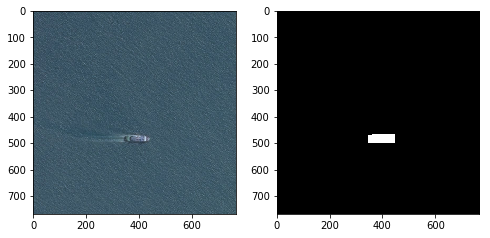

In [20]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(1,2,1)
plt.imshow(test_x)
fig.add_subplot(1,2,2)
plt.imshow(test_y)

In [21]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [22]:
ims = [open_image(PATH/x_names[i]) for i in range(16)]
im_masks = [open_image(PATH/y_names[i]) for i in range(16)]

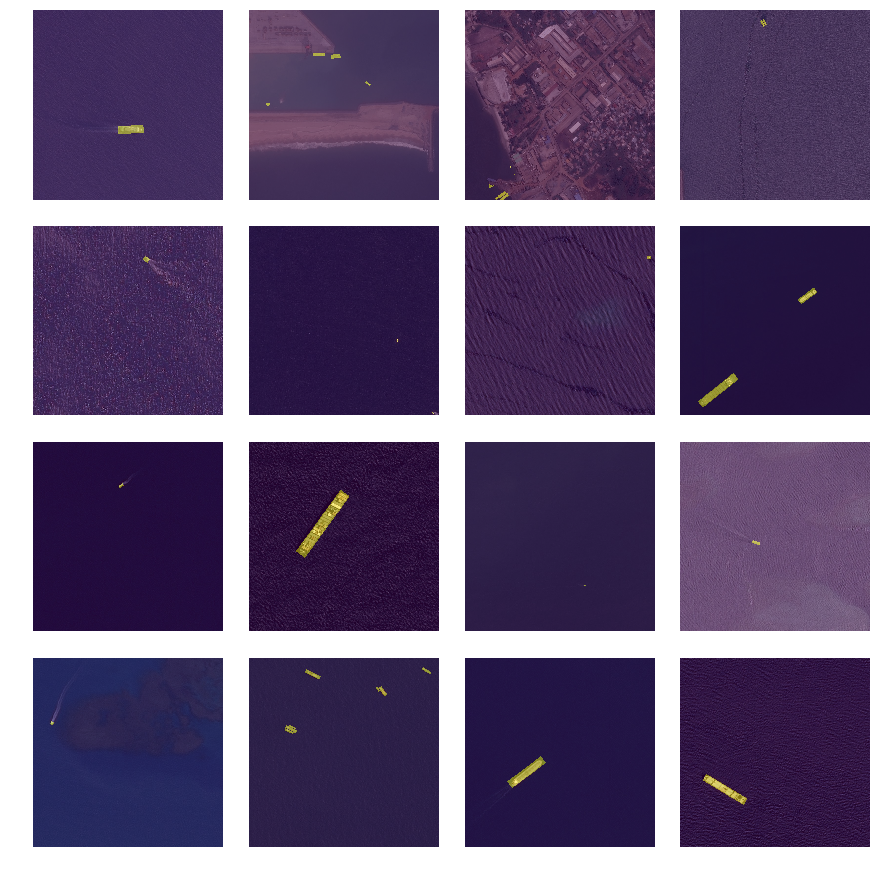

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [26]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [27]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [28]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [29]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [30]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [31]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [32]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [33]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [34]:
sz = 256
bs = 48

tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [35]:
md = md.resize(256, 'tmp')

In [36]:
os.makedirs(PATH/'tmp/256/masks/', exist_ok=True)
os.makedirs(PATH/'tmp/256/models/', exist_ok=True)

In [36]:
from shutil import copy2

In [38]:
for fn in mask_fns:
    copy2(PATH/'masks'/fn, PATH/'tmp/256/masks'/fn)

In [36]:
it = iter(md.trn_dl)
x,y = next(it)

In [37]:
x.shape,y.shape

(torch.Size([48, 3, 256, 256]), torch.Size([48, 256, 256]))

In [37]:
f = resnet34
cut,lr_cut = model_meta[f]

In [38]:
cut, lr_cut

(8, 6)

In [40]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [39]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [40]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [41]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [42]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

Here we train the model on 256x256 images. Notice that for the first epoch the model scores 99.7% accuracy, but only has a dice score of 75%. This is the effect of the class imbalance. The first training block trains only the layers after the encoder. The second training block unfreezes the model and trains every layer, resulting in a dice score of 87.9%.

In [45]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]

In [46]:
learn.freeze_to(1)

 82%|█████████████████████████████████████████████████████████▏            | 616/754 [04:08<00:55,  2.48it/s, loss=1.8]

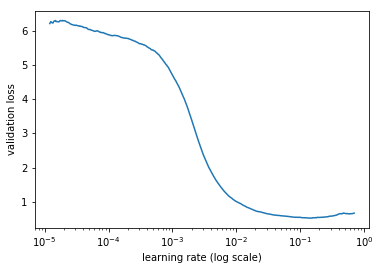

In [50]:
learn.lr_find()
learn.sched.plot()

In [51]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [52]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.367146   0.377047   0.997794   0.759004   0.613933  
    1      0.288314   0.320617   0.998037   0.795122   0.661618                                                        
    2      0.267707   0.269532   0.998288   0.821925   0.698836                                                        
    3      0.262305   0.265169   0.998341   0.824439   0.702712                                                        
    4      0.254063   0.242338   0.998443   0.838378   0.722694                                                        
    5      0.231813   0.229343   0.998526   0.845841   0.73381                                                         
    6      0.214011   0.223274   0.998547   0.850024   0.740012                                                        
    7      0.217105   0.215703   0.998585   0.854407   0.746505                               

[0.1979435196462403,
 0.9986947536767323,
 0.8654592703656121,
 0.7634150314980982]

In [53]:
learn.save('256_r34_1')

In [ ]:
learn.load('256_r34_1')

In [54]:
learn.unfreeze()
learn.bn_freeze(True)

In [55]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.178505   0.19466    0.998715   0.867784   0.767025  
    1      0.17779    0.190533   0.998745   0.870171   0.770772                                                        
    2      0.171578   0.188846   0.998753   0.871099   0.772225                                                        
    3      0.172554   0.186271   0.998771   0.872795   0.774944                                                        
    4      0.163993   0.181724   0.998794   0.875855   0.779683                                                        
    5      0.163033   0.179935   0.998805   0.87704    0.781529                                                        
    6      0.162994   0.179569   0.998806   0.876881   0.781315                                                        
    7      0.165723   0.177162   0.998821   0.878567   0.783971                               

[0.17544782397497902,
 0.9988311088871437,
 0.8797841977124377,
 0.7858963072832225]

In [56]:
learn.save('256_r34_2')

In [57]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

Here we can see areas in which the model typically struggles. It correctly identifies every ship in the image. However, the masks are blobby, rather than having the sharp corners of the ground truth mask. In fact the model prefers to mask only the ship itself, leading to difficulties in replicating the ground truth masks.

The model also struggles to separate ships that are next to each other, preferring to classify them all as a single object.

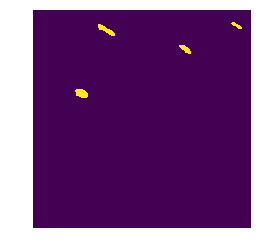

In [58]:
show_img(py[3] > 0)

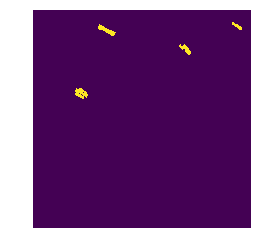

In [59]:
show_img(y[3])

# 512x512

Now we increase the image size to 512x512 and continue training.

In [60]:
sz = 512
bs = 14

In [61]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [62]:
md = md.resize(512, 'tmp')

In [63]:
os.makedirs(PATH/'tmp/512/masks/', exist_ok=True)
os.makedirs(PATH/'tmp/512/models/', exist_ok=True)

In [64]:
for fn in mask_fns:
    copy2(PATH/'masks'/fn, PATH/'tmp/512/masks'/fn)

In [65]:
copy2(PATH/'tmp/256/models/256_r34_2.h5', PATH/'tmp/512/models/')

'F:\\ships\\tmp\\512\\models\\256_r34_2.h5'

In [66]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [67]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]

In [68]:
learn.freeze_to(1)

In [69]:
learn.load('256_r34_2')

 68%|█████████████████████████████████████████████                     | 1766/2584 [11:58<05:33,  2.46it/s, loss=0.898]

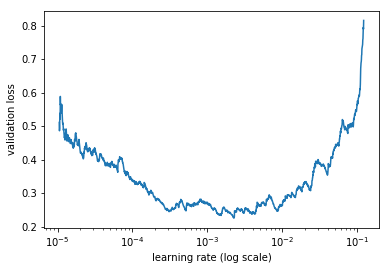

In [70]:
learn.lr_find()
learn.sched.plot()

In [71]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [72]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.20126    0.20648    0.998703   0.860541   0.758702  
    1      0.19053    0.179549   0.998845   0.877065   0.783146                                                        
    2      0.167932   0.168454   0.998909   0.884335   0.794422                                                        
    3      0.160386   0.162098   0.998949   0.888294   0.800697                                                        
    4      0.149346   0.157657   0.998974   0.891119   0.805231                                                        


[0.15765728231051976,
 0.9989741634990137,
 0.8911189321214347,
 0.8052312636681714]

In [73]:
learn.save('512_r34_1')

In [74]:
learn.unfreeze()
learn.bn_freeze(True)

Training at this image size increases the dice score to 89.3.

In [75]:
learn.fit(lrs/10,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.14604    0.157239   0.998979   0.891647   0.806126  
    1      0.149588   0.156214   0.998985   0.892156   0.806927                                                        
    2      0.145757   0.155404   0.99899    0.892785   0.807963                                                        
    3      0.157645   0.154956   0.998993   0.893094   0.808458                                                        
    4      0.142126   0.154969   0.998992   0.893018   0.808334                                                        


[0.15496914572202541,
 0.9989920675184927,
 0.8930181278790984,
 0.8083343859397186]

In [76]:
learn.save('512_r34_2')

# 768x768

Finally we train on full size 768x768 images.

In [43]:
sz = 768
bs = 6

In [44]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [79]:
copy2(PATH/f'tmp/512/models/512_r34_2.h5', PATH/f'models/')

'F:\\ships\\models\\512_r34_2.h5'

In [45]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [46]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]

In [82]:
learn.freeze_to(1)

In [83]:
learn.load('512_r34_2')

 60%|███████████████████████████████████████▊                          | 3642/6029 [23:31<15:24,  2.58it/s, loss=0.717]

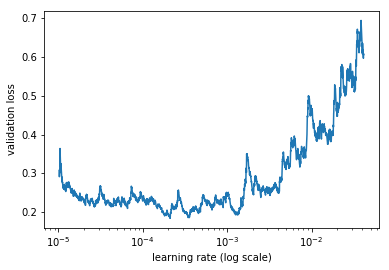

In [84]:
learn.lr_find()
learn.sched.plot()

In [85]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [86]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.206165   0.204162   0.998823   0.862997   0.766454  
    1      0.206211   0.185735   0.998933   0.87425    0.783253                                                        
    2      0.19352    0.171071   0.998986   0.882044   0.793666                                                        
    3      0.153902   0.156915   0.999073   0.891423   0.808541                                                        
    4      0.159421   0.149873   0.999108   0.895903   0.815623                                                        


[0.14987298815546038,
 0.9991079148838331,
 0.8959027836824424,
 0.8156232332223339]

In [87]:
learn.save('768_r34_1')

In [47]:
learn.unfreeze()
learn.bn_freeze(True)

Training on full size images brings the dice score to 89.99

In [89]:
learn.fit(lrs/10,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.140463   0.147419   0.999123   0.897639   0.81833   
    1      0.150151   0.145796   0.99913    0.8985     0.819677                                                        
    2      0.142684   0.145052   0.999135   0.899169   0.820717                                                        
    3      0.150585   0.144329   0.999139   0.899597   0.821425                                                        
    4      0.139405   0.143756   0.999141   0.899975   0.821968                                                        


[0.14375629796165482,
 0.9991409047987512,
 0.8999754052802386,
 0.8219675962153262]

In [90]:
learn.save('768_r34_2')

In [91]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

Comparing to the model trained on 256x256 images, the model is now much better at producing square-ish masks. The model still struggles to separate ships docked together.

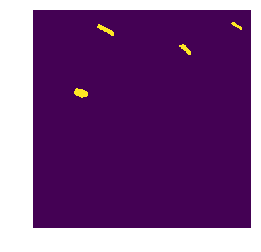

In [92]:
show_img(py[3] > 0)

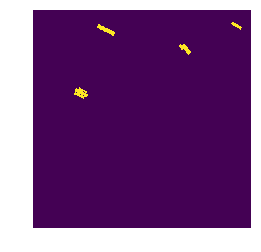

In [93]:
show_img(y[3])

To fine tune the model, we train for a few epochs using a Lovasz loss, adapted from [this repo](https://github.com/bermanmaxim/LovaszSoftmax)

In [48]:
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / union
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
        ious.append(iou)
    ious = map(mean, zip(*ious)) # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.elu(errors_sorted) +1, Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, only_present=False, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), only_present=only_present)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), only_present=only_present)
    return loss


def lovasz_softmax_flat(probas, labels, only_present=False):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    C = probas.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float() # foreground for class c
        if only_present and fg.sum() == 0:
            continue
        errors = (Variable(fg) - probas[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [49]:
class LovaszLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        probs = torch.sigmoid(input)
        
        loss = self.alpha * self.focal(input, target) + lovasz_softmax(probs.unsqueeze(1), target)
        return loss.mean()

In [50]:
learn.crit = LovaszLoss(10, 2)

In [51]:
learn.load('768_r34_2')

 43%|██████████████████████████████                                        | 2593/6029 [19:35<25:58,  2.21it/s, loss=1]

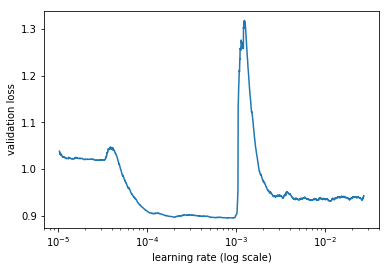

In [52]:
learn.lr_find(end_lr=1000)
learn.sched.plot()

In [53]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/50,lr/10,lr])

In [54]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.894734   0.905061   0.997484   0.695274   0.558768  
    1      0.88988    0.891366   0.998709   0.849389   0.749565                                                        
    2      0.888861   0.889073   0.998894   0.892695   0.810716                                                        
    3      0.888293   0.888796   0.998993   0.897427   0.817782                                                        
    4      0.888175   0.888526   0.999012   0.90259    0.826162                                                        


[0.8885257733703015, 0.9990122527906593, 0.9025900561421452, 0.826162069895864]

In [55]:
learn.save('768_L_1')

This brings our dice score to 91.0

In [56]:
learn.fit(lr/5,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.888375   0.888603   0.998994   0.900724   0.82338   
    1      0.888086   0.888365   0.999037   0.905216   0.830449                                                        
    2      0.88833    0.888258   0.999062   0.907663   0.834019                                                        
    3      0.888356   0.888155   0.999033   0.909183   0.836732                                                        
    4      0.88799    0.888095   0.999067   0.910245   0.838568                                                        


[0.8880946587922337,
 0.9990666957460338,
 0.9102452771614734,
 0.8385684289529595]

In [57]:
learn.save('768_L_2')

In [59]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

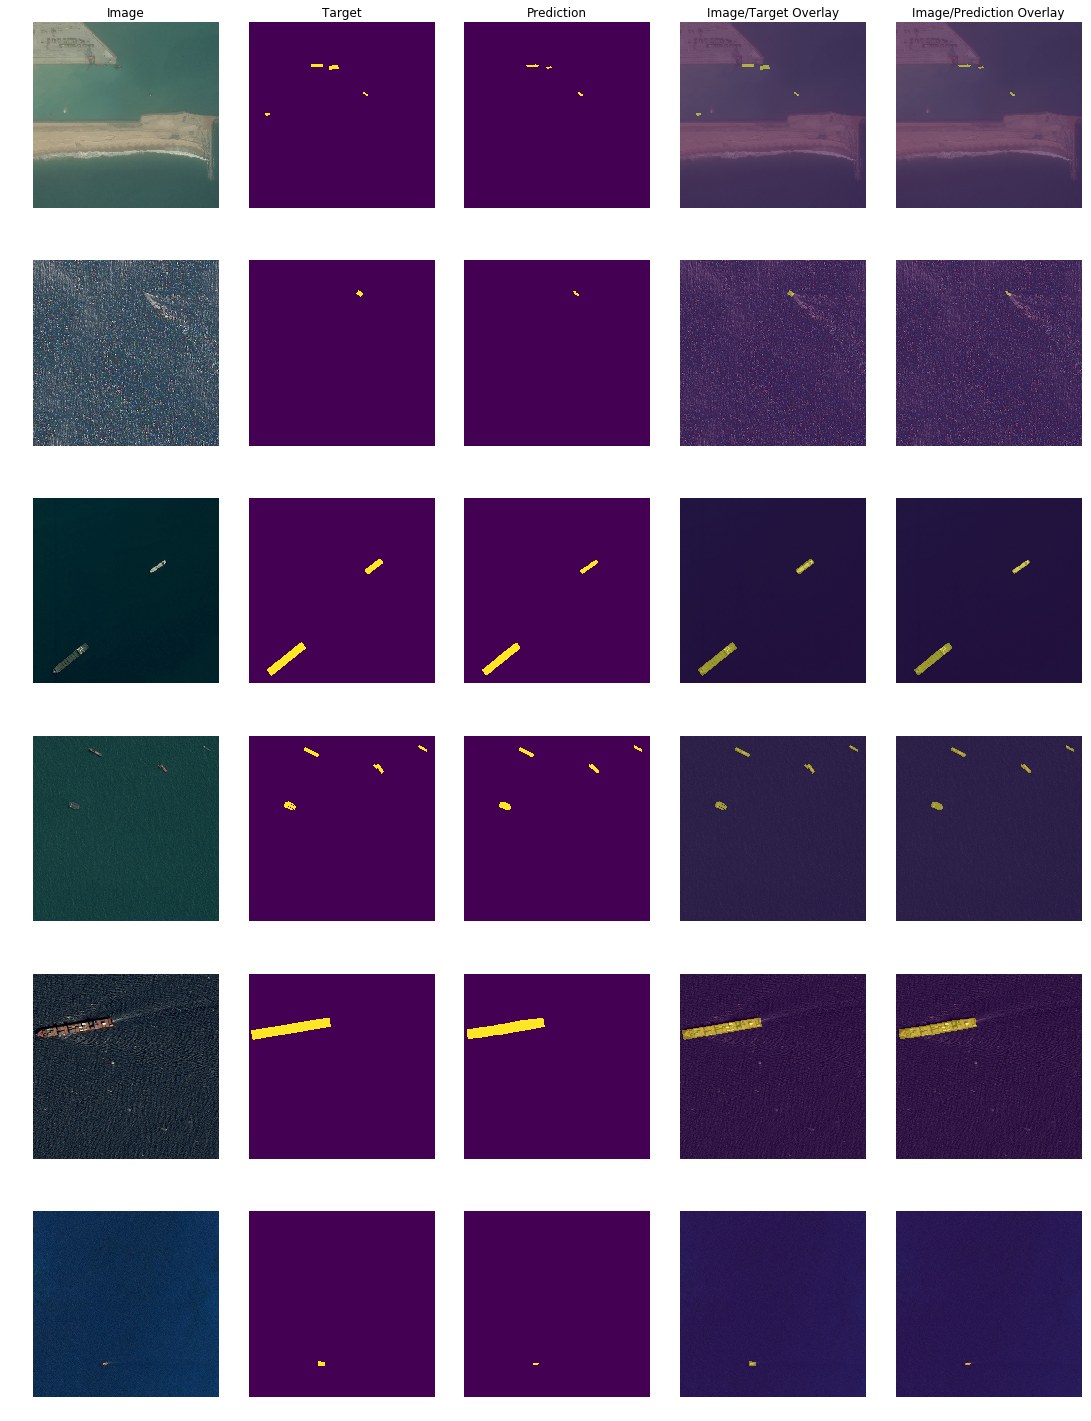

In [60]:
fig, axes = plt.subplots(6 , 5, figsize = (15,20))

cols = ['Image', 'Target', 'Prediction', 'Image/Target Overlay', 'Image/Prediction Overlay']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(6):
    axes[i][0] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i], ax = axes[i][1])
    axes[i][2] = show_img(py[i] > 0, ax = axes[i][2])
    axes[i][3] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][3])
    axes[i][3] = show_img(y[i], ax = axes[i][3], alpha=0.5)
    axes[i][4] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][4])
    axes[i][4] = show_img(py[i] > 0, ax = axes[i][4], alpha=0.5)
    
plt.tight_layout(pad=0.1)